In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 보스턴 주택 가격 데이터 셋
from keras.datasets import boston_housing
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

## 1. Standard Scaling해준다.

In [5]:
mean = train_data.mean(axis = 0)  # 평균값을 가지고 작업을 한다.

* 여기에서는 Standard Scaling을 사용해서 정규화를 시켜준다.

In [6]:
# 트레이닝 데이터에서 평균을 뺀 것이다.
train_data -= mean
# train_data = train_data - mean 와 같은 표현

In [7]:
# 표준 편차를 구한다.
std = train_data.std(axis = 0)  # 넘파이에서는 표준편차를 구할 수 있어서 축 0번으로 표준편차를 구한다. 

In [8]:
train_data /= std
# train_data = train_data / std

In [9]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

* 정규화를 해 놓아서 0을 기점으로 수치화 되어 있다는 것을 알 수 있다.

In [10]:
mean = test_data.mean(axis = 0)
test_data -= mean
std = test_data.std(axis = 0)
test_data /= std

In [11]:
test_data

array([[ 2.8040301 , -0.50784934,  0.96960877, ...,  0.90513041,
        -4.27829517,  2.51324773],
       [-0.55530596, -0.50784934, -0.17801704, ..., -0.28485844,
         0.3909446 ,  0.58604286],
       [-0.56808398, -0.50784934, -0.86176938, ...,  0.90513041,
         0.41570668, -0.38506427],
       ...,
       [-0.23539182, -0.50784934,  1.17955762, ..., -1.82192738,
         0.32313459, -1.55879807],
       [-0.5113909 , -0.50784934, -0.71849348, ..., -0.48318992,
         0.34967446, -0.38956708],
       [-0.03148414, -0.50784934,  1.17955762, ..., -1.82192738,
        -1.57465677, -0.3745577 ]])

* 정규화를 해 놓아서 0을 기점으로 수치화 되어 있다는 것을 알 수 있다.

## 2. 신경망을 만든다.

In [12]:
# 신경망을 만든다.

from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],))) # 13개인데 64개로 넣어주어서 넉넉하게 넣어준 것이다. / 트레이닝 데이터의 모양의 열부분인 1을 넣어준다.(input_shape의 개수는 딱 맞춰서 해주는게 좋다.)
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1))

  model.compile(optimizer = 'rmsprop',
                loss = 'mse',
                metrics = ['mae']) # 절대평균 오차를 메트릭으로 넣는다.
  return model

## 3. k-folder 검증

In [13]:
# K-folder 검증
k = 4

num_val_samples = len(train_data) // k # 폴더의 사이즈, # //를 사용해서 나머지는 버린다.
# print(num_val_samples)

all_scores = [] # 반복할 때 마다 요소를 추가시켜 준다.

for i in range(k):
  print('처리중인 폴드 #',i) # 처리중인 폴드가 몇번째인지를 나타내준다.

  # 검증 데이터를 준비: k번째 분할
  val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples] # 검증용 데이터와 라벨을 가지고 왔다.
  val_labels = train_labels[i * num_val_samples : (i + 1) * num_val_samples]
  # print(val_data)

  # 훈련 데이터의 준비:
  partial_train_data = np.concatenate(
  [train_data[: i * num_val_samples], # 제일 처음에는 아무것도 안가지고 온다.
  train_data[(i + 1) * num_val_samples:]], axis = 0) # concatenate를 사용해서 두개의 값을 합쳐준다.
    # axis = 0번축을 기준으로 합친다.

  partial_train_labels = np.concatenate(
  [train_labels[: i * num_val_samples], 
  train_labels[(i + 1) * num_val_samples:]], axis = 0)

  model = build_model()
  model.fit(partial_train_data, 
            partial_train_labels,
            epochs = 20, # 폴드가 총 4개여서 80번 돌리는 거다.
            batch_size = 1,
            verbose = 0)
  
  val_mse, val_mae = model.evaluate(val_data, val_labels, verbose = 0) # 두개를 가지고 평가를 한다.
  all_scores.append(val_mae)

  print(i, (i+1) * num_val_samples) # 몇번에서 몇번을 가지고 오는지 볼 수 있다. 

처리중인 폴드 # 0
0 101
처리중인 폴드 # 1
1 202
처리중인 폴드 # 2
2 303
처리중인 폴드 # 3
3 404


* concatenate는 두개의 결과를 하나로 합쳐준다. 그런데 축을 지정해주어야 한다.
* verbose = 0이렇게 하면 출력되는 결과를 보여주는 것을 숨길 수 있다.(fit과 evaluate 부분에서)

In [14]:
all_scores

[2.0814905166625977, 2.304978847503662, 2.6365857124328613, 2.927511692047119]

In [15]:
np.mean(all_scores)

2.48764169216156

* 4개의 폴더로 만들어서 평균내서 나온값

In [16]:
# K-folder 검증
k = 4
num_epochs = 500  # 에포크를 500번 돌린다. 

num_val_samples = len(train_data) // k 
all_scores = [] 

for i in range(k):
  print('처리중인 폴드 #',i) 

  # 검증 데이터를 준비: k번째 분할
  val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples] 
  val_labels = train_labels[i * num_val_samples : (i + 1) * num_val_samples]
  # print(val_data)

  # 훈련 데이터의 준비:
  partial_train_data = np.concatenate(
  [train_data[: i * num_val_samples], 
  train_data[(i + 1) * num_val_samples:]], axis = 0) 
    

  partial_train_labels = np.concatenate(
  [train_labels[: i * num_val_samples], 
  train_labels[(i + 1) * num_val_samples:]], axis = 0)

  model = build_model()
  history = model.fit(partial_train_data,  # history에 그때그때마다 저장을 해준다.
            partial_train_labels,
            epochs = num_epochs, # 각 폴드마다 500번씩 돌아간다.
            batch_size = 1, # 메모리를 아끼기 위해 batch_size를 1로 잡은 것이다.
            validation_data = (val_data, val_labels), # fit하면서 검증을 해준다.  그래서 validation으로 검증한 결과이다.
            verbose = 0)
  
  mae_history = history.history['mae'] # 히스토리에서 mae의 값을 가지고 온다.

  # val_mse, val_mae = model.evaluate(val_data, val_labels, verbose = 0) 
  all_scores.append(mae_history) # mae의 값을 all_scores에 append시킨다.

  # print(i, (i+1) * num_val_samples) 

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


* 각 폴더마다 500번씩 돌아서 나온다.

In [39]:
average_mae_history = [np.mean([x[i] for x in all_scores]) for i in range(num_epochs)]

Text(0, 0.5, 'Validation MAE')

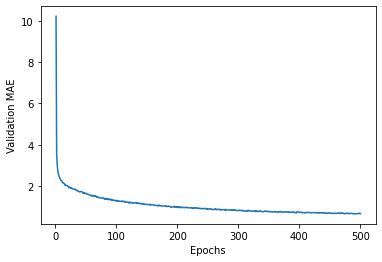

In [40]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history) # x축은 반복 횟수만큼 나온다.
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

* 4번 반복한 결과를 출력해서 내놓은 결과이다.
* 에포크가 80번 정도가 괜찮은 거 같다.

# END